# Using NCBI Datasets command-line tools to get genome, gene and ortholog data


### Table of contents
* [Part I: Accessing genomes](#Part-I)
* [Part II: Accessing genes](#Part-II)
* [Part III: Accessing orthologs](#Part-III)
* [Links](#Links)

### Important resources
- Find this notebook on Github: https://github.com/ncbi/datasets/tree/master/training/TAGC-2024
- Explore NCBI Datasets command-line tool documentation: https://www.ncbi.nlm.nih.gov/datasets/docs/download-and-install/

## Before we start... What is a jupyter notebook?

Jupyter Notebooks are a web-based approach to interactive code. A single notebook (the file you are currently reading) is composed of many "cells" which can contain either text, or code. To navigate between cells, either click, or use the arrow keys on your keyboard.

A text cell will look like... well... this! While a code cell will look something like what you see below. To run the code inside a code cell, click on it, then click the "Run" button at the top of the screen. Try it on the code cell below!

In [1]:
#This is a code cell
print('You ran the code cell!')

You ran the code cell!


If it worked, you should have seen text pop up underneath the cell saying `You ran the code cell!`. Note the `In [1]:` that appeared next to the cell. This tells you the order you have run code cells throughout the notebook. The next time you run a code cell, it will say `In [2]:`, then `In [3]:` and so on... This will help you know if/when code has been run.

The remainder of the notebook below has been pre-built by the workshop organizer. You will not need to create any new cells, and you will be explicitly told if/when to execute a code cell.

The code in this workshop is all Bash (i.e., terminal commands). Bash commands are prefixed with `!` or the cells have the notation `%%bash` at the top. If you are not familiar with code, don't feel pressured to interpret it very deeply. Descriptions of each code block will be provided!

(Jupyter Notebook explanation by Cooper Park at the workshop on [Finding and Analyzing Metagenomic Data](https://www.nlm.nih.gov/oet/ed/ncbi/2021_10_meta.html))

### Mic check

Let's first make sure that the conda environment is active and that we can run datasets.

In [2]:
%%bash
conda info --envs

# conda environments:
#
                         /Users/eric/miniconda3
base                     /opt/anaconda3
datasets13               /opt/anaconda3/envs/datasets13
ncbi_datasets            /opt/anaconda3/envs/ncbi_datasets
tagc                  *  /opt/anaconda3/envs/tagc



In [3]:
%%bash
# Now let's make sure the datasets command-line tool is working 
datasets

datasets is a command-line tool that is used to query and download biological sequence data
across all domains of life from NCBI databases.

Refer to NCBI's [download and install](https://www.ncbi.nlm.nih.gov/datasets/docs/v2/download-and-install/) documentation for information about getting started with the command-line tools.

Usage
  datasets [command]

Data Retrieval Commands
  summary     Print a data report containing gene, genome or virus metadata
  download    Download a gene, genome or virus dataset as a zip file
  rehydrate   Rehydrate a downloaded, dehydrated dataset

Miscellaneous Commands
  completion  Generate autocompletion scripts

Flags
      --api-key string   Specify an NCBI API key
      --debug            Emit debugging info
      --help             Print detailed help about a datasets command
      --version          Print version of datasets

Use datasets <command> --help for detailed help about a command.


## Case study: Drosophila melanogaster innate immunity

Drosophila melanogaster innate immunity features two pathways involved in the detection of dsRNA: RNAi and the cGAS-STING pathway.

Components of the cGAS-STING pathway are present in diverse metazoan lineages but absent in others. For example, the cGAS-STING pathway is present in Drosophila melanogaster, cnidarians (jellyfish) and humans, but absent in nematodes, e.g., C. elegans. 

<div>
<img src=https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41559-022-01951-4/MediaObjects/41559_2022_1951_Fig2_HTML.png?as=webp width="800">
</div>

Iwama, R.E., Moran, Y. Origins and diversification of animal innate immune responses against viral infections. Nat Ecol Evol 7, 182–193 (2023). https://doi.org/10.1038/s41559-022-01951-4

We'll use `datasets` to gather genomic data from NCBI. We will:

- get metadata for all genomes for the genus *Drosophila*
- download genome sequences for the species *Drosophila pseudoobscura*
- download the *cglr1* gene annotated on the *Drosophila pseudoobscura* reference genome
- download some ortholog data for this gene

### How is `datasets` organized?

`datasets` is a command line tool that allows users to download data packages (data + metadata) or look at metadata summaries for genomes, genes and ortholog sets. The program follows a hierarchy that makes it easy for users to select exactly which options they would like to use. In addition to the program commands, additional flags are available for filtering the results. We will go over those during this tutorial.
<img src="https://www.ncbi.nlm.nih.gov/datasets/docs/v2/images/datasets1.png" alt="datasets" style="width: 700px;"/>

### `dataformat`

Now we are going to combine `datasets` with another tool called `dataformat`. `dataformat` allows you to extract metadata information from the JSON-Lines data report files included with all `datasets` data packages or accessible through `summary` command. You can use `dataformat` to:
- Create a tab-delimited file (.tsv) or excel file with the fields you need
- Quickly visualize the information on the screen

<img src="https://www.ncbi.nlm.nih.gov/datasets/docs/v2/images/dataformat1.png" alt="dataformat"  style="width: 700px;"/>

In [4]:
%%bash
# Read the dataformat help menu. This is a great way to get a list of the available metadata fields.
dataformat tsv genome --help


Convert Genome Assembly Data Report into TSV format.

Refer to NCBI's [download and install](https://www.ncbi.nlm.nih.gov/datasets/docs/v2/download-and-install/) documentation for information about getting started with the command-line tools.

Usage
  dataformat tsv genome [flags]

Examples
  dataformat tsv genome --inputfile human/ncbi_dataset/data/assembly_data_report.jsonl
  dataformat tsv genome --package human.zip

Flags
      --fields strings     Comma-separated list of fields
                               - accession
                               - ani-best-ani-match-ani
                               - ani-best-ani-match-assembly
                               - ani-best-ani-match-assembly_coverage
                               - ani-best-ani-match-category
                               - ani-best-ani-match-organism
                               - ani-best-ani-match-type_assembly_coverage
                               - ani-best-match-status
                             

## Part I: Accessing genomes<a class="anchor" id="Part-I"></a>

First, let's figure out what kind of genome information NCBI has for the genus Drosophila. For this task, we will first use the `datasets summary` command, as shown in the diagram below. We will then pipe the `datasets` output to `jq` so we can see how many Drosophila genomes are in the NCBI database.

<img src="https://www.ncbi.nlm.nih.gov/datasets/docs/v2/images/datasets-s-genome-tax.png" style="width: 800px;"/>

In [5]:
%%bash
# Get the genome count for the genus Drosophila (Taxid: 7215)
datasets summary genome taxon 7215 | jq '.total_count'


661


Now we know that there are 661 Drosophila genomes at NCBI. Let's save the metadata as a JSON-Lines file using the flag `--as-json-lines` to make it easier to extract information from the metadata file later.

In [6]:
%%bash
# Get genome metadata for the genus Drosophila and save to a file
datasets summary genome taxon 7215 --as-json-lines > drosophila.jsonl

**Now let's take a look at the metadata using jq**  
Since the output is really long, we will only show the first 50 lines (`head -n 50`). The flag `-C` in the `jq` command shows the output in color, which makes it easier to read.

In [7]:
%%bash

jq -C . drosophila.jsonl | head -n 20


{
  "accession": "GCA_035046005.1",
  "assembly_info": {
    "assembly_level": "Contig",
    "assembly_method": "Flye v. 2.9; purge_dups v. 1.2.6; Medaka v. 1.8; Pilon v. 1.23; NCBI FCS v. 0.3.0",
    "assembly_name": "ASM3504600v1",
    "assembly_status": "current",
    "assembly_type": "haploid",
    "bioproject_accession": "PRJNA1020440",
    "bioproject_lineage": [
      {
        "bioprojects": [
          {
            "accession": "PRJNA1020440",
            "title": "Genome sequencing and assembly of many species of Family Drosophilidae Genome sequencing and assembly"
          }
        ]
      }
    ],
    "biosample": {


### Let's continue to explore the available genomes for the genus Drosophila


For this part, we will use two UNIX commands: `sort` and `uniq`. 

- `sort` can be used to sort text files line by line, numerically and alphabetically.   
- `uniq` will filter out the repeated lines in a file. However, `uniq` can only detect repeated lines if they are adjacent to each other. In other words, if they are alphabetically or numerically sorted. The flag `-c` or `--count` tells the command `uniq` to remove the repeated lines, and to count how many times each value appeared. 

So, we will use `dataformat` to extract the information we need, sort the result and count the number of unique entries.

In [8]:
%%bash
# Which Drosophila species have the most genomes?

dataformat tsv genome --inputfile drosophila.jsonl --fields organism-name --elide-header | sort | uniq -c | sort -k1nr | head

 119 Drosophila melanogaster
  45 Drosophila simulans
  10 Drosophila ananassae
  10 Drosophila nasuta
  10 Drosophila subobscura
   9 Drosophila biarmipes
   9 Drosophila triauraria
   9 Drosophila virilis
   8 Drosophila obscura
   8 Drosophila pseudoobscura


### How to get help when using the command line

Since `datasets` is a hierarchical program, we can use that characteristic to our advantage to get specific help.   For example: if we type `datasets --help`, we will see the first level of commands available.


In [9]:
%%bash
datasets --help

datasets is a command-line tool that is used to query and download biological sequence data
across all domains of life from NCBI databases.

Refer to NCBI's [download and install](https://www.ncbi.nlm.nih.gov/datasets/docs/v2/download-and-install/) documentation for information about getting started with the command-line tools.

Usage
  datasets [command]

Data Retrieval Commands
  summary     Print a data report containing gene, genome or virus metadata
  download    Download a gene, genome or virus dataset as a zip file
  rehydrate   Rehydrate a downloaded, dehydrated dataset

Miscellaneous Commands
  completion  Generate autocompletion scripts

Flags
      --api-key string   Specify an NCBI API key
      --debug            Emit debugging info
      --help             Print detailed help about a datasets command
      --version          Print version of datasets

Use datasets <command> --help for detailed help about a command.


Notice the difference from when we type `datasets summary genome taxon --help`  


In [10]:
%%bash
datasets summary genome taxon --help


Print a data report containing genome metadata by taxon (NCBI Taxonomy ID, scientific or common name at any tax rank). The data report is returned in JSON format.

Usage
  datasets summary genome taxon [flags]

Sample Commands
  datasets summary genome taxon human
  datasets summary genome taxon "mus musculus"
  datasets summary genome taxon 10116

Flags
      --assembly-version string   Limit to 'latest' assembly accession version or include 'all' (latest + previous versions)
                                     (default "latest")
      --tax-exact-match           Exclude sub-species when a species-level taxon is specified


Global Flags
      --annotated                Limit to annotated genomes
      --api-key string           Specify an NCBI API key
      --as-json-lines            Output results in JSON Lines format
      --assembly-level string    Limit to genomes at one or more assembly levels (comma-separated):
                                   * chromosome
                  

### Data package

We explored the `datasets summary` option, in which we had a chance to look at the summary metadata ***without*** downloading any files. In the next steps, we will look at the data packages, which contain the actual data files. 

<br>

<img src="https://www.ncbi.nlm.nih.gov/datasets/docs/v2/images/data-packages.png" alt="data_package" style="width:600px;" />
<br>

Each `datasets` data package type (e.g., `genome`, `gene`, `virus`) has a different file content. You can customize data packages by using the flag `--include` to add or remove files. The image below shows the file types available for each `datasets` data package type. Refer to the [NCBI Datasets Data Package Reference page](https://www.ncbi.nlm.nih.gov/datasets/docs/v2/reference-docs/data-packages/) for more information about each data package type.

<br>

<img src="https://www.ncbi.nlm.nih.gov/datasets/docs/v2/images/data-package-contents-op2.png" style="width:800px;">

In [11]:
%%bash
# Download a genome data package containing all chromosome-level GenBank assemblies for the species Drosophila pseudoobscura

datasets download genome taxon 'drosophila pseudoobscura' --assembly-source genbank --assembly-level chromosome --filename pseudoobscura.zip --no-progressbar

In [12]:
%%bash
# Unzip to the folder genomes
unzip pseudoobscura.zip -d genomes

Archive:  pseudoobscura.zip
  inflating: genomes/README.md       
  inflating: genomes/ncbi_dataset/data/assembly_data_report.jsonl  
  inflating: genomes/ncbi_dataset/data/GCA_000001765.3/GCA_000001765.3_Dpse_4.0_genomic.fna  
  inflating: genomes/ncbi_dataset/data/GCA_004329205.1/GCA_004329205.1_UCBerk_Dpse_1.0_genomic.fna  
  inflating: genomes/ncbi_dataset/data/GCA_009870125.2/GCA_009870125.2_UCI_Dpse_MV25_genomic.fna  
  inflating: genomes/ncbi_dataset/data/GCA_020698565.1/GCA_020698565.1_ST_MC_genomic.fna  
  inflating: genomes/ncbi_dataset/data/dataset_catalog.json  


In [13]:
%%bash
# Explore the folder structure of the folder genome with the command tree
tree -C genomes/

genomes/
├── README.md
└── ncbi_dataset
    └── data
        ├── GCA_000001765.3
        │   └── GCA_000001765.3_Dpse_4.0_genomic.fna
        ├── GCA_004329205.1
        │   └── GCA_004329205.1_UCBerk_Dpse_1.0_genomic.fna
        ├── GCA_009870125.2
        │   └── GCA_009870125.2_UCI_Dpse_MV25_genomic.fna
        ├── GCA_020698565.1
        │   └── GCA_020698565.1_ST_MC_genomic.fna
        ├── assembly_data_report.jsonl
        └── dataset_catalog.json

7 directories, 7 files


In [14]:
%%bash
# Now download the genomes and gff3 files for all *Drosophila pseudoobscura* genomes annotated by NCBI
datasets download genome taxon 'drosophila pseudoobscura' --assembly-source refseq \
    --include genome,gff3 --filename pseudoobscura-rs-gff3.zip --no-progressbar

unzip -l pseudoobscura-rs-gff3.zip

Archive:  pseudoobscura-rs-gff3.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
     1596  03-22-2024 08:57   README.md
     3301  03-22-2024 08:57   ncbi_dataset/data/assembly_data_report.jsonl
165334118  03-22-2024 08:57   ncbi_dataset/data/GCF_009870125.1/GCF_009870125.1_UCI_Dpse_MV25_genomic.fna
110703141  03-22-2024 08:57   ncbi_dataset/data/GCF_009870125.1/genomic.gff
      431  03-22-2024 08:57   ncbi_dataset/data/dataset_catalog.json
---------                     -------
276042587                     5 files


Note that this is only a single genome! Although there are 10 genomes for Drosophila pseudoobscura, there is only a single genome annotated by NCBI.

### Downloading large genome datasets (dehydration/rehydration)

Now you know how to download genome data for a relatively small number of genomes. But what if you want large amounts of genome data? `datasets` provides a better way to download large genome data packages that takes a few more steps but allows you to resume interrupted downloads. Let's download a dehydrated package and explore the files inside it.

In [15]:
%%bash
# Download a dehydrated data package of chromosome-level GenBank assemblies for the species Drosophila pseudoobscura
datasets download genome taxon 'drosophila pseudoobscura' --assembly-source genbank --assembly-level chromosome --dehydrated --filename pseudoobscura-dry.zip --no-progressbar

In [16]:
%%bash
# Next we have to unzip the dehydrated package
unzip -q pseudoobscura-dry.zip -d pseudoobscura-dry
# And we'll use tree to visualize the structure of the extracted archive
tree -C pseudoobscura-dry

pseudoobscura-dry
├── README.md
└── ncbi_dataset
    ├── data
    │   ├── assembly_data_report.jsonl
    │   └── dataset_catalog.json
    └── fetch.txt

3 directories, 4 files


The file `fetch.txt` has a list of files to be "fetched" (downloaded) with paths on NCBI servers.

In [17]:
%%bash
# Let's get a list of files that are available for download 
datasets rehydrate --directory pseudoobscura-dry/ --list

data/GCA_000001765.3/GCA_000001765.3_Dpse_4.0_genomic.fna
data/GCA_004329205.1/GCA_004329205.1_UCBerk_Dpse_1.0_genomic.fna
data/GCA_009870125.2/GCA_009870125.2_UCI_Dpse_MV25_genomic.fna
data/GCA_020698565.1/GCA_020698565.1_ST_MC_genomic.fna


In [18]:
%%bash
# Now let's rehydrate the package to get the data
datasets rehydrate --directory pseudoobscura-dry/ --no-progressbar

Found 4 of 4 files for rehydration
Done


In [19]:
%%bash
# Next we'll view the contents of the directory
tree -C pseudoobscura-dry

pseudoobscura-dry
├── README.md
└── ncbi_dataset
    ├── data
    │   ├── GCA_000001765.3
    │   │   └── GCA_000001765.3_Dpse_4.0_genomic.fna
    │   ├── GCA_004329205.1
    │   │   └── GCA_004329205.1_UCBerk_Dpse_1.0_genomic.fna
    │   ├── GCA_009870125.2
    │   │   └── GCA_009870125.2_UCI_Dpse_MV25_genomic.fna
    │   ├── GCA_020698565.1
    │   │   └── GCA_020698565.1_ST_MC_genomic.fna
    │   ├── assembly_data_report.jsonl
    │   └── dataset_catalog.json
    └── fetch.txt

7 directories, 8 files


## Part II: Accessing genes <a class="anchor" id="Part-II"></a>
### GENES

Independent of choosing `datasets download` or `datasets summary`, there are four options for retrieving gene information: `accession`, `gene-id`, `symbol` and `taxon`. 


<img src="https://www.ncbi.nlm.nih.gov/datasets/docs/v2/images/datasets-gene.png" style="width: 700px;"/>


When choosing any of those options, you will retrieve the gene information for the gene annotated on the **reference** genome. Like this:

`datasets download gene accession NM_176180.2`  
`datasets download gene gene-id 36744`  
`datasets download gene symbol cglr1 --taxon 'drosophila melanogaster'`  
`datasets download gene taxon 'drosophila melanogaster'`. 

The first three commands will download the same gene annotated on the (<i>Drosophila melanogaster</i>) <u>reference genome</u>, and the last one will download all genes for that species. 

- **accession**:  Unique identifier. Accession includes RefSeq RNA and protein accessions. Since it's unique, taxon is implied (aka there will never be two sequences from different taxa with the same accession number).  

- **gene-id**:  Also a unique identifier. For example: the gene-id for BRCA1 in human is 672, while the gene-id for domestic cat BRCA1 is 101081937.  

- **symbol**: Gene symbols are not unique and can be used multiple times in different taxonomic groups. If using the symbol option, you should specify the species. If no taxon is specified, it is assumed the taxon is human.

- **taxon**: Species-level. Retrieves the entire set of RefSeq annotated genes for the specified taxon.  

**Remember**  
Both `summary` and `download` will return results for the **reference assembly** of a <u>single species</u>. If you want to download a curated set of related genes from multiple taxa, you should use the flag `--ortholog`. We'll talk more about that later. 

Now let's take a look at a gene example:

In [20]:
%%bash
# Get metadata for a gene by symbol in human 
datasets summary gene symbol cgas | jq . -C | head -20

{
  "reports": [
    {
      "gene": {
        "annotations": [
          {
            "annotation_name": "GCF_000001405.40-RS_2023_10",
            "annotation_release_date": "2023-10-02",
            "assembly_accession": "GCF_000001405.40",
            "assembly_name": "GRCh38.p14",
            "genomic_locations": [
              {
                "genomic_accession_version": "NC_000006.12",
                "genomic_range": {
                  "begin": "73423711",
                  "end": "73452297",
                  "orientation": "minus"
                },
                "sequence_name": "6"
              }


In [21]:
%%bash
# Get metadata for a gene by symbol in Drosophila melanogaster
datasets summary gene symbol cglr1 --taxon 'drosophila melanogaster' | jq -C . 


{
  "reports": [
    {
      "gene": {
        "annotations": [
          {
            "annotation_name": "FlyBase Release 6.54",
            "annotation_release_date": "2023-12-26",
            "assembly_accession": "GCF_000001215.4",
            "assembly_name": "Release 6 plus ISO1 MT",
            "genomic_locations": [
              {
                "genomic_accession_version": "NT_033778.4",
                "genomic_range": {
                  "begin": "15855961",
                  "end": "15857522",
                  "orientation": "plus"
                },
                "sequence_name": "2R"
              }
            ]
          }
        ],
        "chromosomes": [
          "2R"
        ],
        "common_name": "fruit fly",
        "description": "cGAS-like receptor 1",
        "gene_groups": [
          {
            "id": "36744",
            "method": "NCBI Ortholog"
          }
        ],
        "gene_id": "36744",
        "nomenclature_authority": {
          "au

In [22]:
%%bash
# View select fields of metadata for the same gene
datasets summary gene symbol cglr1 --taxon 'drosophila melanogaster' --as-json-lines | \
    dataformat tsv gene --fields tax-name,symbol,description,gene-id,protein-count

Taxonomic Name	Symbol	Description	NCBI GeneID	Proteins
Drosophila melanogaster	cGlr1	cGAS-like receptor 1	36744	1


### Downloading gene sequence data 
We know that there is 1 protein encoded by the Drosophila melanogaster cglr1 gene. Let's see how we can download the protein sequence, and the underlying transcript and gene sequences.


In [23]:
%%bash
# Download gene, transcript and protein sequences for *Drosophila melanogaster* cglr1.
datasets download gene symbol cglr1 --taxon 'drosophila melanogaster' --include gene,rna,protein --filename cglr1.zip --no-progressbar

In [24]:
%%bash
# Unzip the gene data package
unzip cglr1.zip -d cglr1

Archive:  cglr1.zip
  inflating: cglr1/README.md         
  inflating: cglr1/ncbi_dataset/data/gene.fna  
  inflating: cglr1/ncbi_dataset/data/rna.fna  
  inflating: cglr1/ncbi_dataset/data/protein.faa  
  inflating: cglr1/ncbi_dataset/data/data_report.jsonl  
  inflating: cglr1/ncbi_dataset/data/dataset_catalog.json  


In [25]:
%%bash
# Take a look at the FASTA headers for the downloaded sequences
head -2 cglr1/ncbi_dataset/data/*.f*

==> cglr1/ncbi_dataset/data/gene.fna <==
>NT_033778.4:15855961-15857522 cGlr1 [organism=Drosophila melanogaster] [GeneID=36744] [chromosome=2R]
ATGGCGATGAATTTGGAAAATATCGTCAATCAGGCCACCGCCCAATACGTGAAAATTAAAGAGCACCGCG

==> cglr1/ncbi_dataset/data/protein.faa <==
>NP_788360.2 cGlr1 [organism=Drosophila melanogaster] [GeneID=36744]
MAMNLENIVNQATAQYVKIKEHREPYTAHYNALKDKVYSEWKSSAVLGKLLKGSTLCGGYGDKLKVSIPD

==> cglr1/ncbi_dataset/data/rna.fna <==
>NM_176180.2 cGlr1 [organism=Drosophila melanogaster] [GeneID=36744]
ATGGCGATGAATTTGGAAAATATCGTCAATCAGGCCACCGCCCAATACGTGAAAATTAAAGAGCACCGCG


### Using orthology data to find genes in related species


In [26]:
%%bash
# If we try to retrieve metadata information for this gene using the symbol cglr1, what happens?
datasets summary gene symbol cglr1 --taxon "drosophila pseudoobscura"


{"total_count": 0}


We can use orthology data to find related genes in other species. 

In [27]:
%%bash
datasets summary gene symbol cglr1 --taxon "drosophila melanogaster" --ortholog "drosophila melanogaster, drosophila pseudoobscura" --as-json-lines | \
    dataformat tsv gene --fields tax-name,gene-id,description,symbol,group-method,group-id

Taxonomic Name	NCBI GeneID	Description	Symbol	Gene Group Method	Gene Group Identifier
Drosophila pseudoobscura	6899115	uncharacterized LOC6899115	LOC6899115	NCBI Ortholog	36744
Drosophila melanogaster	36744	cGAS-like receptor 1	cGlr1	NCBI Ortholog	36744


In [28]:
%%bash
# Download the gene data package for the gene-id 4803562 (ortholog of *cglr1* in Drosophila pseudoobscura)
# We want to include the FASTA file with gene sequences, so we will use the flag --include.

datasets download gene gene-id 4803562 --filename gene.zip --include gene,protein,rna --no-progressbar


In [29]:
%%bash
datasets download gene gene-id 4803562 --include cds,rna,protein --filename all.zip --no-progressbar

In [30]:
%%bash
# Unzip the file
unzip all.zip -d all

Archive:  all.zip
  inflating: all/README.md           
  inflating: all/ncbi_dataset/data/cds.fna  
  inflating: all/ncbi_dataset/data/rna.fna  
  inflating: all/ncbi_dataset/data/protein.faa  
  inflating: all/ncbi_dataset/data/data_report.jsonl  
  inflating: all/ncbi_dataset/data/dataset_catalog.json  


In [32]:
%%bash
head all/ncbi_dataset/data/cds.fna

>XM_001360232.4:1406-2743 LOC4803562 [organism=Drosophila pseudoobscura] [GeneID=4803562] [region=cds]
ATGTTAAAGATCGCGAAACCCAACGAATTCGATTTGGTATTTAAGCTCCGTATTCCGCATTACCGGGAAA
TAATCGTGACGCGAGATTCGGAAATGCCGGGCAACGTTTTACTCGATATAACGCGCGTACTTCAACTACT
CAAAAGCGATCCCCGCGAGGATCAACAGAATATCCGCCGGCTGTTAAAATCTCTCGTAAACGCTCAAAAC
TTCCTCATCGTGGAAAAGCTGCACCACTGGCTCCAAAGCCTATTCAGTCGCACTCTCAACCGGCTCGATC
ATCGGATCGTAGTGGATGGCAAGGCATCTAAGTTAAAGTATCGCACTTGTGGGCCGGCCCACACCATCGA
GGTCGAAGGAATGGAATATTCGGTTGATTTTGTGCCTGCCATCCGACTGGATGCCGAGCAGAACGTGTTT
CGGACCGAACAGTTGAATTACCACGCGAACATACACTACTGGGATGCGATACCCAAACCATTAAAAAAAC
CGCTCATAACCGAAAGTATTTCATTTCGATCTTCCTTTTACGATGCCGAGAAGGCGATGTTAAGGGGTAA
ACACGAAAATTGCCGGAATGTAATCAAGTGCATTAAGAAATTTCGCGATGTTCAGACGAATTTATACAAC


In [33]:
%%bash
# Explore the data package structure using tree
tree -C all/

all/
├── README.md
└── ncbi_dataset
    └── data
        ├── cds.fna
        ├── data_report.jsonl
        ├── dataset_catalog.json
        ├── protein.faa
        └── rna.fna

3 directories, 6 files


## Part III: Accessing orthologs <a class="anchor" id="Part-III"></a>

### Orthologs

Since `datasets` version 14, users can retrieve ortholog information using the flag `--ortholog` with the `gene` subcommand.

#### <font color='blue'>Wait, but what is an ortholog set?</font>

>An ortholog set, or ortholog gene group, is a group of genes that have been identified by the NCBI genome annotation team as homologous genes that are separated by speciation events. They are identified by a combination of protein similarity + local synteny information. 
Currently, NCBI has ortholog sets calculated for vertebrates and some insects. 


#### Examples:

`datasets download gene accession NM_176180.2 --ortholog all`  
`datasets download gene gene-id 36744 --ortholog all`  
`datasets download gene symbol cglr1 --taxon 'drosophila melanogaster' --ortholog all`  

All three commands will download the **same** ortholog set (which is the complete set). 

What if I want to filter the ortholog set to include *only* a taxonomic group of interest?



### Applying a taxonomic filter to the ortholog set

When using the `--ortholog` flag, users need to provide an argument for it. The argument should be one or more taxa (any rank) to filter results or 'all' for the complete set.

#### Examples

- `datasets download gene symbol cglr1 --taxon 'drosophila melanogaster' --ortholog apidae`  
Prints a json metadata summary of gene orthologs of the drosophila melanogaster gene cglr1, but only from the family apidae (bees).


#### We are going to follow these steps:
- download a gene data package containing orthologs and save it with the name ortholog.zip
- unzip it to the folder ortholog
- look at some metadata for the genes in the ortholog set
- align the protein sequences for the genes in the set

In [34]:
%%bash
# download the cglr1 ortholog set for the genus Drosophila (Taxid: 7215)
datasets download gene symbol cglr1 --taxon 'drosophila melanogaster' --ortholog apidae,'drosophila melanogaster' --filename ortholog.zip --no-progressbar

In [35]:
%%bash
# Unzip it to the folder ortholog
unzip ortholog.zip -d ortholog


Archive:  ortholog.zip
  inflating: ortholog/README.md      
  inflating: ortholog/ncbi_dataset/data/rna.fna  
  inflating: ortholog/ncbi_dataset/data/protein.faa  
  inflating: ortholog/ncbi_dataset/data/data_report.jsonl  
  inflating: ortholog/ncbi_dataset/data/dataset_catalog.json  


In [36]:
%%bash
# Generate a table describing the genes in the ortholog set
dataformat tsv gene --inputfile ortholog/ncbi_dataset/data/data_report.jsonl \
--fields tax-name,symbol,gene-id,group-method,group-id | head

Taxonomic Name	Symbol	NCBI GeneID	Gene Group Method	Gene Group Identifier
Apis mellifera	LOC100577693	100577693	NCBI Ortholog	36744
Apis dorsata	LOC102671149	102671149	NCBI Ortholog	36744
Drosophila melanogaster	cGlr1	36744	NCBI Ortholog	36744


In [37]:
%%bash
# Update FASTA headers in the protein sequence file to make clustalo output easier to understand
sed 's/ /_/g' ortholog/ncbi_dataset/data/protein.faa > renamed.proteins

# Run alignment
clustalo --infile renamed.proteins --full --outfmt=clu --force

CLUSTAL O(1.2.4) multiple sequence alignment


NP_788360.2_cGlr1_[organism=Drosophila_melanogaster]_[GeneID=36744]           MAMNLENIVNQATAQYVKIKEHREPYTAHYNALKDKVYSEWKSSAVLGKLLKGSTLCGGY
XP_031370638.1_LOC102671149_[organism=Apis_dorsata]_[GeneID=102671149]        -----------------------MYNSPKYDLLSDK------------------------
XP_006557488.1_LOC100577693_[organism=Apis_mellifera]_[GeneID=100577693]      ------------------------MYNSKYDHLTDK------------------------
                                                                                                        . :*: *.**                        

NP_788360.2_cGlr1_[organism=Drosophila_melanogaster]_[GeneID=36744]           GDKLKVSIPDEFDLLIHLVFPENDKIIVKADASKPGNVILDMTKVMEIIGSQEHNKPVFD
XP_031370638.1_LOC102671149_[organism=Apis_dorsata]_[GeneID=102671149]        -----------------------------------G-------------------KKIYN
XP_006557488.1_LOC100577693_[organism=Apis_mellifera]_[GeneID=100577693]      -----------------------------------G----

## What have we done so far?
- Explored metadata for all genomes for the genus Drosophila
- Downloaded genomes for the species Drosophila pseudoobscura
- Downloaded the *cglr1* gene from *Drosophila melanogastr*
- Downloaded the ortholog set for *Drosophila melanogaster* *cglr1*, including orthologs in *Drosophila pseudoobscura* and bees (apidae)

## Links<a class="anchor" id="Links"></a>

### NCBI Datasets main resources

- NCBI Datasets homepage: [https://www.ncbi.nlm.nih.gov/datasets/](https://www.ncbi.nlm.nih.gov/datasets/)
- Github: [https://github.com/ncbi/datasets](https://github.com/ncbi/datasets)


### Download and installation instructions (CLI)

- Instructions:  
 [https://www.ncbi.nlm.nih.gov/datasets/docs/v2/download-and-install/](https://www.ncbi.nlm.nih.gov/datasets/docs/v2/download-and-install/)
  
### Tutorials, how-to guides and past workshops
 
- How-to guides (short, one-line CLI tasks):   
[https://www.ncbi.nlm.nih.gov/datasets/docs/v2/how-tos/](https://www.ncbi.nlm.nih.gov/datasets/docs/v2/how-tos/)
- Tutorials (multi-task, longer tutorials, mostly based on feedback or questions we get from users): [https://www.ncbi.nlm.nih.gov/datasets/docs/v2/tutorials/](https://www.ncbi.nlm.nih.gov/datasets/docs/v2/tutorials/)
- Past training sessions and workshops (Jupyter notebooks used in previous *datasets* training events): [https://github.com/ncbi/datasets/tree/master/training](https://github.com/ncbi/datasets/tree/master/training)

### How to get help

- Email the helpdesk: [info@ncbi.nlm.nih.gov](mailto:info@ncbi.nlm.nih.gov)
- Github: [https://github.com/ncbi/datasets](https://github.com/ncbi/datasets)
- Yellow feedback button on our pages

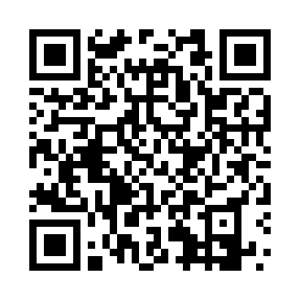